# **Carga de imagenes desde Google drive**

Proyecto de computacion flexible

Red neuronal convolucional para clasificar 12 clases del dataset Food101

Daniel Alejandro Zambrano Roman

NUA 826853

Importar clases a usar:



1.   Sequential para crear una red sequencial,
2.   Dense para crear una capa dense,
3.   Numpy para usar arreglos,
4.   Train_test_split para seleccionar los patrones de prueba y aprendizaje,
5.   Resample para seleccionar los patrones de aprendizaje con reemplazo
6.   Pyplot para graficar las curvas de entrenamiento y prueba.

In [5]:
from tensorflow.keras import models as M
from tensorflow.keras import layers as L
from tensorflow.keras import callbacks as C
from tensorflow.keras import optimizers as O
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers as opt
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, BatchNormalization
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import linear_model
from sklearn import datasets
from sklearn.metrics import classification_report, confusion_matrix
import cv2                                 
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf
import random
import platform
import csv
import pandas as pd
import os
import glob
import PIL
import seaborn as sn
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split



In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
class CyclicLR(C.Callback):
    """Este callback implementa la tasa de aprendizaje cíclica (CLR).
    El método varía cíclicamente la tasa de aprendizaje entre dos valores
    a una frecuencia constante.
    # Arguments
        base_lr: tasa de aprendizaje inicial la cual es el límite
            inferior.
        max_lr: tasa de aprendizaje máxima. Funcionalmente,
            define la amplitud del ciclo (max_lr - base_lr).
            La tasa lr es la suma de base_lr
            y alguna amplitud escalada; por consiguiente
            max_lr pudiera no ser alcanzada dependiendo de
            la función de escalado.
        step_size: número de iteracions de entrenamiento por
            medio ciclo. Los autores sugieren fijar step_size
            a 2-8 x iteraciones en la época.
        mode: uno de {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Los valores corresponden a las políticas detalladas arriba.
            Si scale_fn no es None, este argumento es ignorado.
        gamma: constante de la función de escalado 'exp_range':
            gamma**(iteraciones del ciclo)
        scale_fn: Política de escalado definida por una función lambda
            de un solo argumento, donde
            0 <= scale_fn(x) <= 1 para todo x >= 0.
            el parámetro mode es ignorado
        scale_mode: {'cycle', 'iterations'}.
            Define si scale_fn es evaluado con
            número de ciclo o iteraciones del ciclo (iteraciones
            desde el inicio del ciclo). Default es 'cycle'.
    La amplitud del ciclo puede ser escalada por iteración o
    ciclo.
    Esta clase tiene tres políticas predefinidas.
    "triangular":
        Un ciclo triangular básico sin función de escalado.
    "triangular2":
        Un ciclo triangular básico que escala la amplitud inicial a la mitad 
        en cada ciclo.
    "exp_range":
        Un ciclo que escala la amplitud initial por gamma**(cycle iterations) 
        en cada iteración de un ciclo.
    Para más detalles, ver el paper.
    # Por ejmplo para la base CIFAR-10 con un batch de 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    La clase también soporta funciones de escalado definidas por el usuario:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # Referencias
      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(self,base_lr=0.001,max_lr=0.006,step_size=2000.,
                 mode='triangular',gamma=1.,scale_fn=None,scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2',
                        'exp_range']:
            raise KeyError("el modo debe ser 'triangular', "
                           "'triangular2', o 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Reinicia las iteraciones del ciclo.
        Optionalmente ajuste de tamaño de amplitud/paso.
        """
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
        #print("lr = ", K.get_value(self.model.optimizer.lr))

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [8]:
print('Versión de python = ', platform.python_version())

Versión de python =  3.7.13


In [9]:
print('GPU a usar en tensorflow: ', tf.test.gpu_device_name())

GPU a usar en tensorflow:  /device:GPU:0


In [10]:
seed = 7
np.random.seed(seed)

In [11]:
batch_size = 32
img_height = 128
img_width = 128

In [12]:
directory = "gdrive/My Drive/Proyecto/Imagenes/food_12/*"
quant = 0
eti = 0
a = 0
images = np.zeros([12000,img_height,img_width,3])
labels = np.zeros([12000])
#print("leyendo imagenes de ",directory)
for subdir1 in glob.glob(directory, recursive=True):
    #print(eti)
    for imagef in glob.glob(subdir1 + "/*" , recursive = True):
    #     filepath = os.path.join(root,file)
   
      images[quant,:] = cv2.resize(cv2.imread(imagef),dsize=(img_height,img_width))
      labels[quant] = eti
    #     a+=1
    #     print ("Leyendo..." + str(a), end="\r")
    #     if prevRoot !=root:
    #             print(root, quant)
    #             prevRoot=root
    #             directories.append(root)
    #             dircount.append(quant)
    #             # quant=0
      quant+=1
    eti+=1
    #

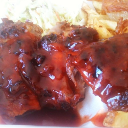

In [13]:

cv2_imshow(images[50,:]) 



In [14]:
labels1 = tf.keras.utils.to_categorical(labels)
print(labels1)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [15]:
images = images/ 255
x_train, x_test, y_train , y_test = train_test_split(images,labels1, test_size=0.3, random_state=42, stratify=labels)



In [16]:
p = 100/x_test.shape[0];
print('pmin = ', p*100, '%')

pmin =  2.7777777777777777 %


### ***Arquitecturas de la CNN***

### **Prueba Nro. 1, 3 capas convolucionales de 32 filtros; Dense 128, 64 y Dropout 0.25, Resultado en validacion 41% de accuracy**

In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.25)),
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(64, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.25)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.25)),
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [ ]:
model.compile(optimizer=opt.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 16, 16, 32)      

In [ ]:
epochs=100
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/100
263/263 [==============================] - 5s 16ms/step - loss: 2.4133 - accuracy: 0.1395 - val_loss: 2.2534 - val_accuracy: 0.2228
Epoch 2/100
263/263 [==============================] - 3s 12ms/step - loss: 2.2127 - accuracy: 0.2305 - val_loss: 2.0899 - val_accuracy: 0.2717
Epoch 3/100
263/263 [==============================] - 3s 12ms/step - loss: 2.1051 - accuracy: 0.2762 - val_loss: 1.9822 - val_accuracy: 0.3211
Epoch 4/100
263/263 [==============================] - 3s 12ms/step - loss: 2.0222 - accuracy: 0.3057 - val_loss: 1.9766 - val_accuracy: 0.3211
Epoch 5/100
263/263 [==============================] - 3s 12ms/step - loss: 1.9591 - accuracy: 0.3398 - val_loss: 1.9334 - val_accuracy: 0.3406
Epoch 6/100
263/263 [==============================] - 3s 13ms/step - loss: 1.8651 - accuracy: 0.3656 - val_loss: 1.9199 - val_accuracy: 0.3531
Epoch 7/100
263/263 [==============================] - 3s 13ms/step - loss: 1.8005 - accuracy: 0.3898 - val_loss: 1.9178 - val_accuracy:

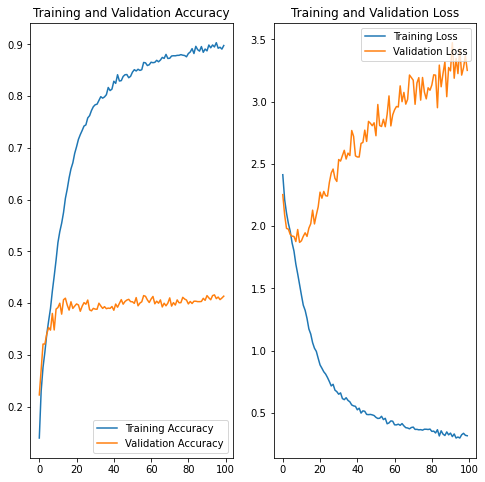

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.29955971240997314
Error mínimo (prueba):  1.869890570640564
Porcentaje de clasificación máximo (entrenamiento):  0.903333306312561
Porcentaje de clasificación máximo (prueba):  0.4161111116409302


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.52      0.55      0.54       300
           1       0.26      0.36      0.30       300
           2       0.49      0.43      0.46       300
           3       0.21      0.15      0.17       300
           4       0.64      0.56      0.60       300
           5       0.42      0.42      0.42       300
           6       0.47      0.50      0.48       300
           7       0.28      0.26      0.27       300
           8       0.73      0.69      0.71       300
           9       0.39      0.52      0.44       300
          10       0.24      0.24      0.24       300
          11       0.36      0.28      0.32       300

    accuracy                           0.41      3600
   macro avg       0.42      0.41      0.41      3600
weighted avg       0.42      0.41      0.41      3600



Text(0.5, 87.0, 'True')

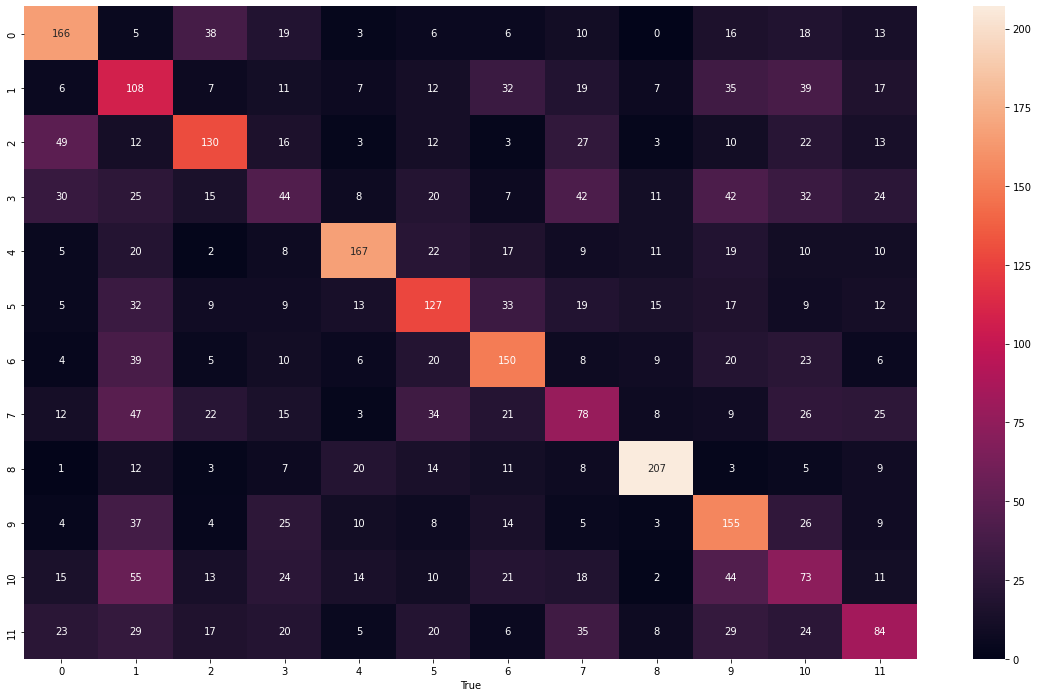

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 2 Dense 256 y 128, 3 capas convolucionales (una de 32 y dos de 64 filtros), dropout de 0.25, Resultado en validacion 43% de accuracy**





In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.25)),
model.add(L.Flatten()),
#----------------------
#model.add(L.Dense(256, kernel_initializer='glorot_normal',activation = 'relu'))
#model.add(L.Dropout(0.25)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.25)),
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [ ]:
model.compile(optimizer=opt.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)      

In [ ]:
epochs=100
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/100
263/263 [==============================] - 5s 18ms/step - loss: 2.4213 - accuracy: 0.1356 - val_loss: 2.2780 - val_accuracy: 0.2128
Epoch 2/100
263/263 [==============================] - 4s 15ms/step - loss: 2.2656 - accuracy: 0.2085 - val_loss: 2.1372 - val_accuracy: 0.2592
Epoch 3/100
263/263 [==============================] - 4s 15ms/step - loss: 2.1887 - accuracy: 0.2380 - val_loss: 2.1004 - val_accuracy: 0.2728
Epoch 4/100
263/263 [==============================] - 5s 18ms/step - loss: 2.1159 - accuracy: 0.2636 - val_loss: 2.0240 - val_accuracy: 0.3325
Epoch 5/100
263/263 [==============================] - 4s 15ms/step - loss: 2.0765 - accuracy: 0.2800 - val_loss: 1.9762 - val_accuracy: 0.3308
Epoch 6/100
263/263 [==============================] - 4s 15ms/step - loss: 2.0373 - accuracy: 0.2915 - val_loss: 1.9281 - val_accuracy: 0.3739
Epoch 7/100
263/263 [==============================] - 4s 15ms/step - loss: 1.9885 - accuracy: 0.3005 - val_loss: 1.9158 - val_accuracy:

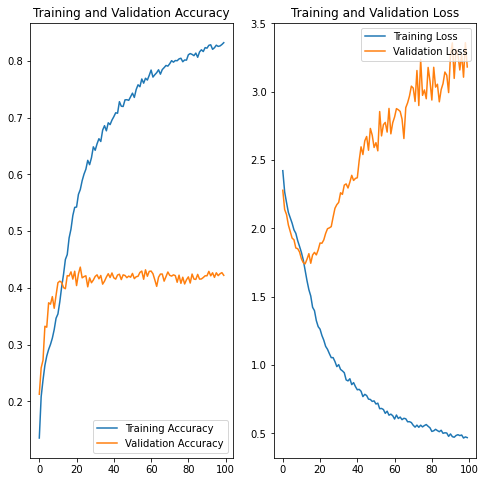

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.46519917249679565
Error mínimo (prueba):  1.7398262023925781
Porcentaje de clasificación máximo (entrenamiento):  0.8320237994194031
Porcentaje de clasificación máximo (prueba):  0.43666666746139526


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.47      0.59      0.52       300
           1       0.29      0.25      0.27       300
           2       0.44      0.40      0.42       300
           3       0.22      0.28      0.25       300
           4       0.59      0.57      0.58       300
           5       0.43      0.37      0.40       300
           6       0.57      0.55      0.56       300
           7       0.30      0.29      0.29       300
           8       0.78      0.73      0.75       300
           9       0.52      0.49      0.50       300
          10       0.30      0.28      0.29       300
          11       0.24      0.25      0.24       300

    accuracy                           0.42      3600
   macro avg       0.43      0.42      0.42      3600
weighted avg       0.43      0.42      0.42      3600



Text(0.5, 87.0, 'True')

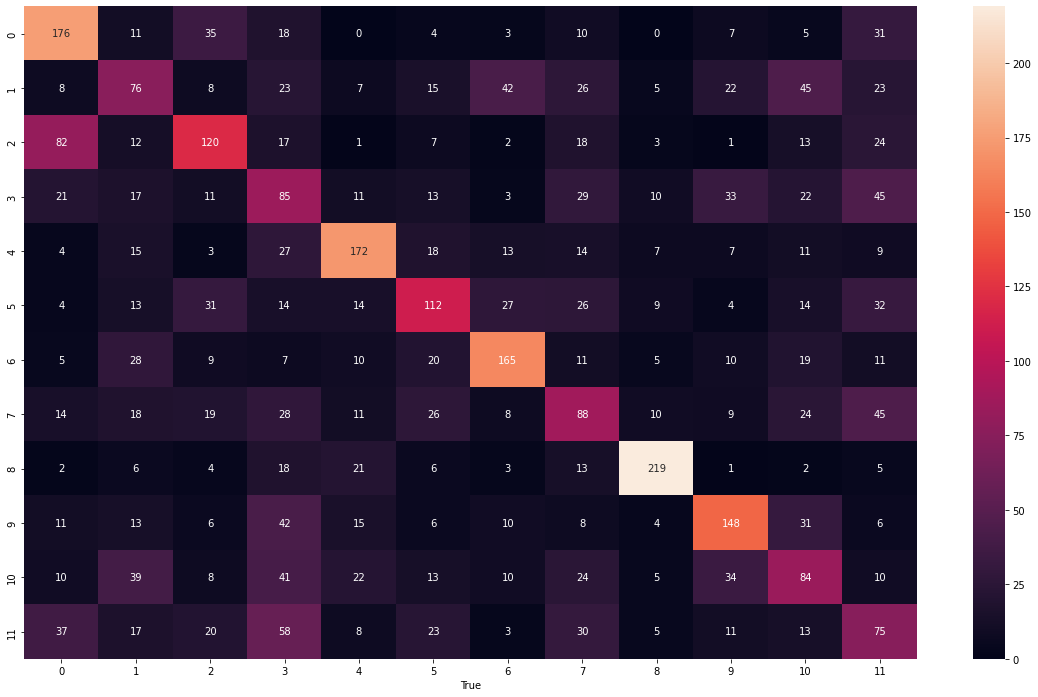

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 3, Dense 128, 64 y dropout de 0.3 en capa convolucional y 0.35 en red neuronal, 3 capas convolucionales de 64, 128, 256 filtros, Resultado de validacion 46.5 % de accuracy**

In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.3)),
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(128, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.35)),
model.add(L.Dense(64, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.35)),
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))


In [ ]:
model.compile(optimizer=opt.Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0

In [ ]:
epochs=100
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/100
263/263 [==============================] - 23s 34ms/step - loss: 2.4574 - accuracy: 0.1179 - val_loss: 2.4749 - val_accuracy: 0.1186
Epoch 2/100
263/263 [==============================] - 8s 31ms/step - loss: 2.2622 - accuracy: 0.2148 - val_loss: 2.0808 - val_accuracy: 0.2944
Epoch 3/100
263/263 [==============================] - 8s 31ms/step - loss: 2.0539 - accuracy: 0.3046 - val_loss: 2.0500 - val_accuracy: 0.3103
Epoch 4/100
263/263 [==============================] - 8s 31ms/step - loss: 1.8879 - accuracy: 0.3686 - val_loss: 1.9179 - val_accuracy: 0.3669
Epoch 5/100
263/263 [==============================] - 8s 31ms/step - loss: 1.7394 - accuracy: 0.4135 - val_loss: 1.7843 - val_accuracy: 0.4008
Epoch 6/100
263/263 [==============================] - 8s 31ms/step - loss: 1.5755 - accuracy: 0.4721 - val_loss: 1.6902 - val_accuracy: 0.4369
Epoch 7/100
263/263 [==============================] - 8s 31ms/step - loss: 1.3817 - accuracy: 0.5438 - val_loss: 1.7316 - val_accuracy

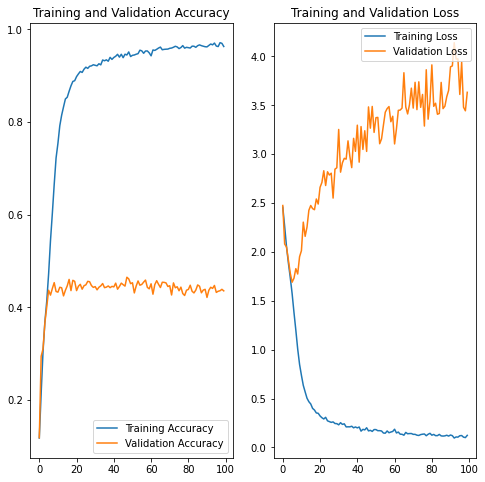

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.09641260653734207
Error mínimo (prueba):  1.6902443170547485
Porcentaje de clasificación máximo (entrenamiento):  0.9713095426559448
Porcentaje de clasificación máximo (prueba):  0.4650000035762787


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.59      0.62      0.61       300
           1       0.33      0.32      0.33       300
           2       0.41      0.49      0.45       300
           3       0.26      0.25      0.25       300
           4       0.62      0.60      0.61       300
           5       0.44      0.28      0.34       300
           6       0.51      0.48      0.50       300
           7       0.32      0.31      0.31       300
           8       0.67      0.74      0.70       300
           9       0.50      0.49      0.49       300
          10       0.24      0.33      0.28       300
          11       0.38      0.31      0.34       300

    accuracy                           0.44      3600
   macro avg       0.44      0.44      0.43      3600
weighted avg       0.44      0.44      0.43      3600



Text(0.5, 87.0, 'True')

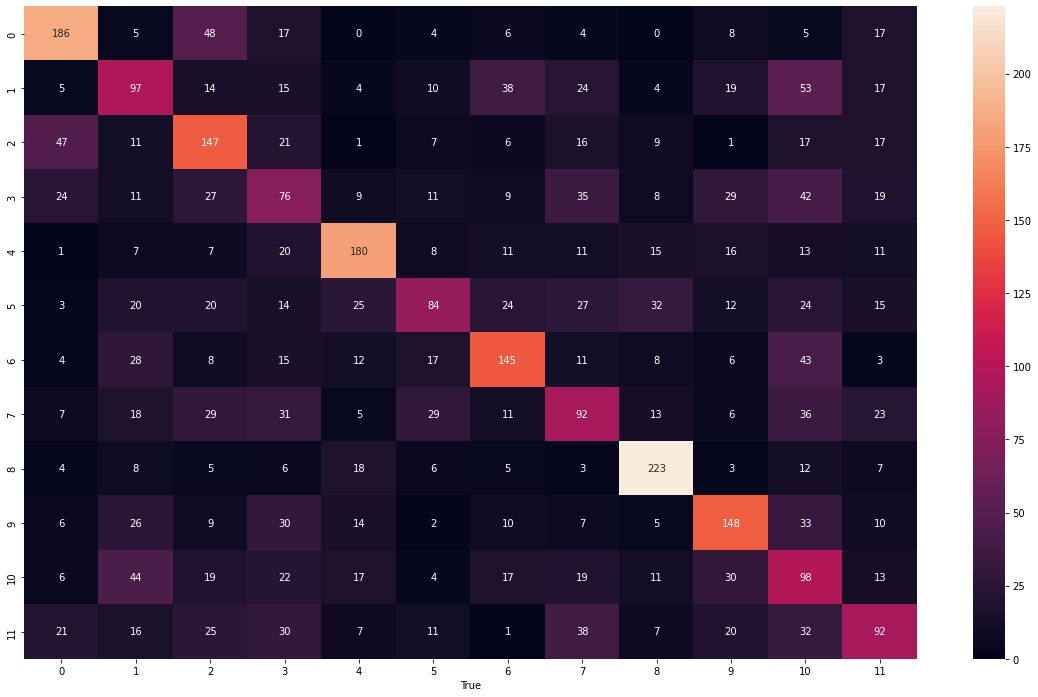

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 4, Learning rate variable con 3 capas convolucionales, resultado en validacion 53.1 % de accuracy**

In [17]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.3)),
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.3)),
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.3)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.3)),
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [18]:
model.compile(optimizer=opt.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [21]:
num_epochs = 200
batchsize = 32
step_size = 3.0 * np.ceil(y_train.shape[0] / batchsize)
clr = CyclicLR(base_lr=0.0001, max_lr=0.002,
                       step_size=step_size, mode='triangular', gamma=0.998)
hist = model.fit(x_train, y_train, 
                 validation_data=(x_test, y_test), 
                 epochs=num_epochs, 
                 batch_size=batchsize,
                 verbose=2,
                 callbacks=[clr])

Epoch 1/200
263/263 - 5s - loss: 1.0852 - accuracy: 0.6294 - val_loss: 1.7391 - val_accuracy: 0.4961 - lr: 7.3207e-04 - 5s/epoch - 20ms/step
Epoch 2/200
263/263 - 5s - loss: 1.1382 - accuracy: 0.6050 - val_loss: 1.7739 - val_accuracy: 0.4733 - lr: 0.0014 - 5s/epoch - 20ms/step
Epoch 3/200
263/263 - 5s - loss: 1.2661 - accuracy: 0.5710 - val_loss: 1.7047 - val_accuracy: 0.4606 - lr: 0.0020 - 5s/epoch - 20ms/step
Epoch 4/200
263/263 - 5s - loss: 1.2897 - accuracy: 0.5621 - val_loss: 1.7191 - val_accuracy: 0.4586 - lr: 0.0014 - 5s/epoch - 20ms/step
Epoch 5/200
263/263 - 5s - loss: 1.1764 - accuracy: 0.5957 - val_loss: 1.6766 - val_accuracy: 0.4947 - lr: 7.3207e-04 - 5s/epoch - 20ms/step
Epoch 6/200
263/263 - 5s - loss: 1.0393 - accuracy: 0.6365 - val_loss: 1.6812 - val_accuracy: 0.5025 - lr: 1.0000e-04 - 5s/epoch - 20ms/step
Epoch 7/200
263/263 - 5s - loss: 1.0148 - accuracy: 0.6474 - val_loss: 1.7335 - val_accuracy: 0.4953 - lr: 7.3080e-04 - 5s/epoch - 20ms/step
Epoch 8/200
263/263 - 5s 

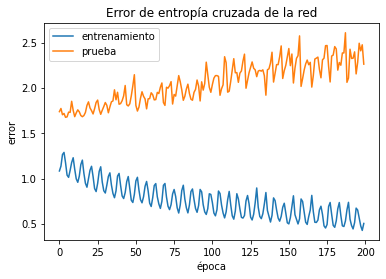

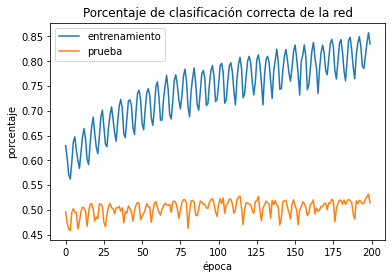

In [24]:
plt.plot(loss)
plt.plot(val_loss)
plt.title('Error de entropía cruzada de la red')
plt.ylabel('error')
plt.xlabel('época')
plt.legend(['entrenamiento', 'prueba'], loc='upper left')
plt.show()
plt.plot(acc)
plt.plot(val_acc)
plt.title('Porcentaje de clasificación correcta de la red')
plt.ylabel('porcentaje')
plt.xlabel('época')
plt.legend(['entrenamiento', 'prueba'], loc='upper left')
plt.show()

In [22]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

In [23]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.4296967685222626
Error mínimo (prueba):  1.6766327619552612
Porcentaje de clasificación máximo (entrenamiento):  0.8575000166893005
Porcentaje de clasificación máximo (prueba):  0.5319444537162781


In [25]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.69      0.55      0.61       300
           1       0.27      0.38      0.31       300
           2       0.57      0.60      0.58       300
           3       0.28      0.35      0.31       300
           4       0.77      0.60      0.67       300
           5       0.50      0.63      0.56       300
           6       0.71      0.59      0.64       300
           7       0.47      0.41      0.44       300
           8       0.77      0.86      0.81       300
           9       0.80      0.52      0.63       300
          10       0.24      0.35      0.28       300
          11       0.64      0.34      0.45       300

    accuracy                           0.51      3600
   macro avg       0.56      0.51      0.53      3600
weighted avg       0.56      0.51      0.53      3600



Text(0.5, 87.0, 'True')

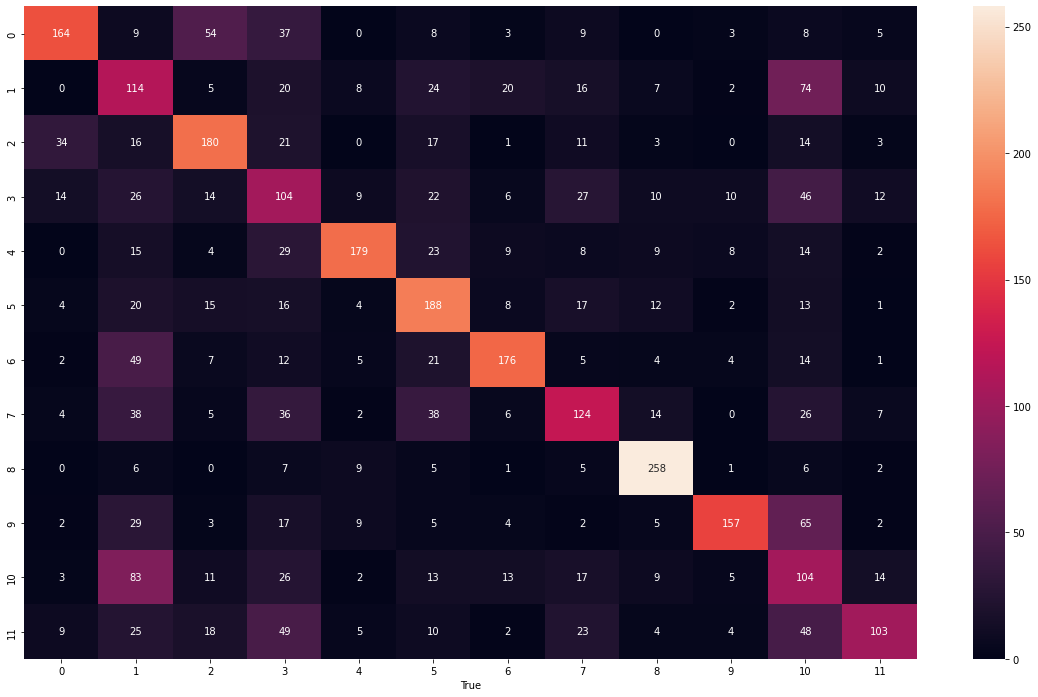

In [26]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 5, Learning rate variable con 3 capas convolucionales, resultado en validacion 53.5 % de accuracy, dropout en todas las capas, tanto convolucionales**

In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.25)),
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.25)),
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.2)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.2)),
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [ ]:
model.compile(optimizer=opt.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 14, 14, 64)      

In [ ]:
epochs=120
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/120
263/263 [==============================] - 7s 24ms/step - loss: 2.4848 - accuracy: 0.0869 - val_loss: 2.4909 - val_accuracy: 0.0833
Epoch 2/120
263/263 [==============================] - 5s 20ms/step - loss: 2.4461 - accuracy: 0.1201 - val_loss: 2.3752 - val_accuracy: 0.1503
Epoch 3/120
263/263 [==============================] - 6s 21ms/step - loss: 2.3196 - accuracy: 0.1627 - val_loss: 2.2539 - val_accuracy: 0.1753
Epoch 4/120
263/263 [==============================] - 5s 20ms/step - loss: 2.2456 - accuracy: 0.1889 - val_loss: 2.2329 - val_accuracy: 0.2272
Epoch 5/120
263/263 [==============================] - 5s 21ms/step - loss: 2.2014 - accuracy: 0.2074 - val_loss: 2.0795 - val_accuracy: 0.2703
Epoch 6/120
263/263 [==============================] - 5s 20ms/step - loss: 2.1146 - accuracy: 0.2521 - val_loss: 2.0368 - val_accuracy: 0.3017
Epoch 7/120
263/263 [==============================] - 5s 20ms/step - loss: 2.0210 - accuracy: 0.2965 - val_loss: 1.8988 - val_accuracy:

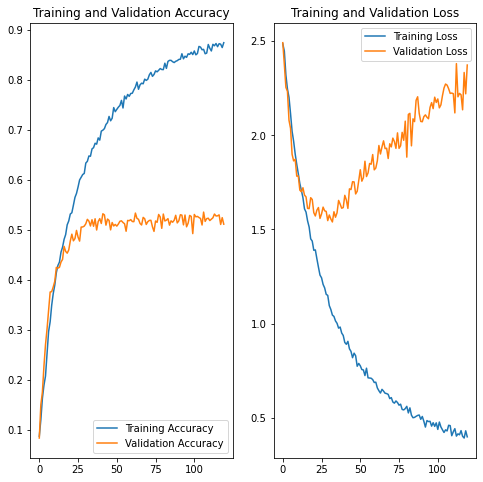

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.39369359612464905
Error mínimo (prueba):  1.5399315357208252
Porcentaje de clasificación máximo (entrenamiento):  0.8746428489685059
Porcentaje de clasificación máximo (prueba):  0.5355555415153503


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.65      0.58      0.61       300
           1       0.31      0.39      0.34       300
           2       0.60      0.51      0.55       300
           3       0.28      0.30      0.29       300
           4       0.73      0.63      0.67       300
           5       0.55      0.46      0.50       300
           6       0.75      0.45      0.56       300
           7       0.45      0.36      0.40       300
           8       0.87      0.82      0.85       300
           9       0.59      0.68      0.63       300
          10       0.26      0.50      0.34       300
          11       0.55      0.46      0.50       300

    accuracy                           0.51      3600
   macro avg       0.55      0.51      0.52      3600
weighted avg       0.55      0.51      0.52      3600



Text(0.5, 87.0, 'True')

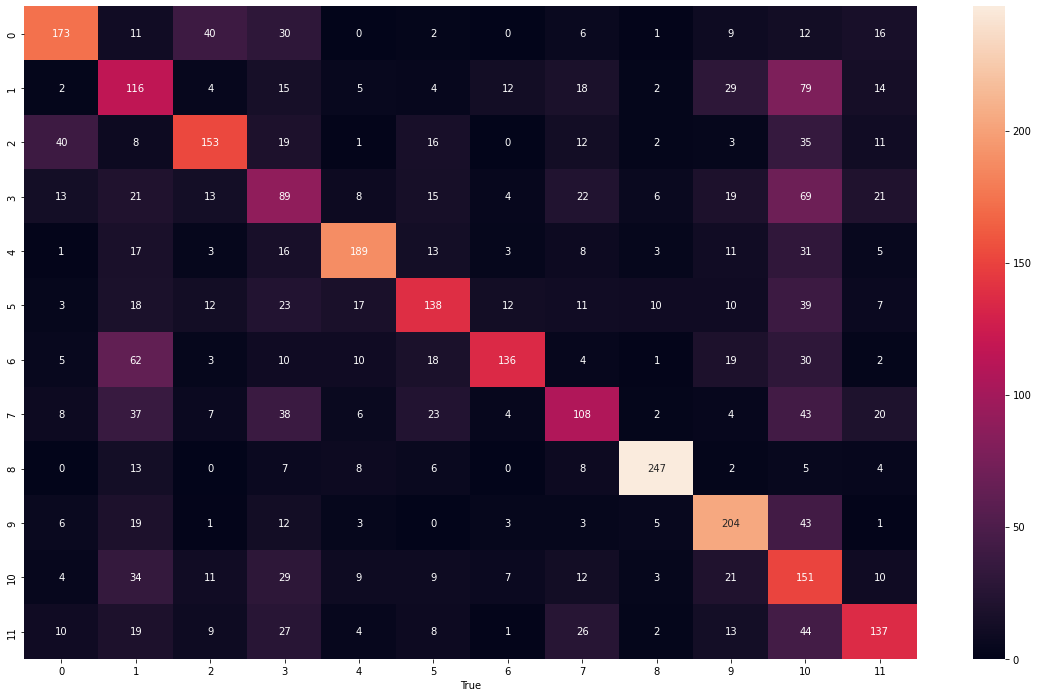

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 6, tres capas convolucionales, dos Dense 64, batchnormalization en capa convolucional, dropout en red neuronal, Resultado en validacion 54.8 % de accuracy**

In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(64, (3, 3), input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization()) # agregado
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization()) # agregado
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.2)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [ ]:
model.compile(optimizer=opt.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_3 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_10 (ReLU)             (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 batch_normalization_4 (Batc  (None, 61, 61, 64)      

In [ ]:
epochs=100
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/100
263/263 [==============================] - 8s 26ms/step - loss: 2.2453 - accuracy: 0.2327 - val_loss: 3.8409 - val_accuracy: 0.1056
Epoch 2/100
263/263 [==============================] - 6s 22ms/step - loss: 2.0200 - accuracy: 0.3206 - val_loss: 3.1613 - val_accuracy: 0.1208
Epoch 3/100
263/263 [==============================] - 6s 23ms/step - loss: 1.9034 - accuracy: 0.3636 - val_loss: 2.0266 - val_accuracy: 0.3192
Epoch 4/100
263/263 [==============================] - 6s 23ms/step - loss: 1.7804 - accuracy: 0.4129 - val_loss: 1.9413 - val_accuracy: 0.3458
Epoch 5/100
263/263 [==============================] - 6s 23ms/step - loss: 1.6864 - accuracy: 0.4442 - val_loss: 1.9921 - val_accuracy: 0.3450
Epoch 6/100
263/263 [==============================] - 6s 23ms/step - loss: 1.6074 - accuracy: 0.4706 - val_loss: 1.8875 - val_accuracy: 0.3814
Epoch 7/100
263/263 [==============================] - 6s 23ms/step - loss: 1.4923 - accuracy: 0.5139 - val_loss: 1.9805 - val_accuracy:

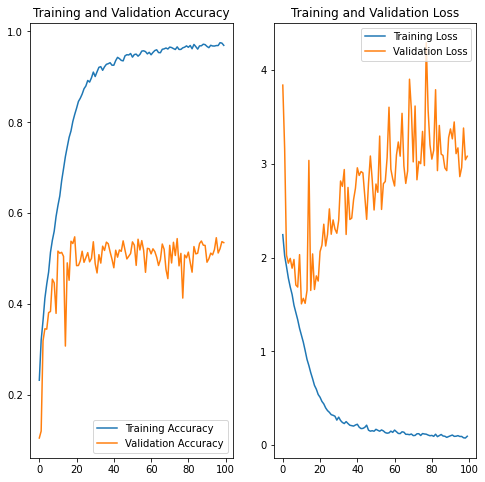

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.07554039359092712
Error mínimo (prueba):  1.5071138143539429
Porcentaje de clasificación máximo (entrenamiento):  0.9750000238418579
Porcentaje de clasificación máximo (prueba):  0.5480555295944214


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.55      0.58       300
           1       0.48      0.30      0.37       300
           2       0.62      0.56      0.59       300
           3       0.35      0.49      0.41       300
           4       0.57      0.67      0.62       300
           5       0.55      0.59      0.57       300
           6       0.64      0.48      0.55       300
           7       0.40      0.36      0.38       300
           8       0.71      0.83      0.76       300
           9       0.62      0.62      0.62       300
          10       0.56      0.37      0.44       300
          11       0.41      0.61      0.49       300

    accuracy                           0.54      3600
   macro avg       0.54      0.54      0.53      3600
weighted avg       0.54      0.54      0.53      3600



Text(0.5, 87.0, 'True')

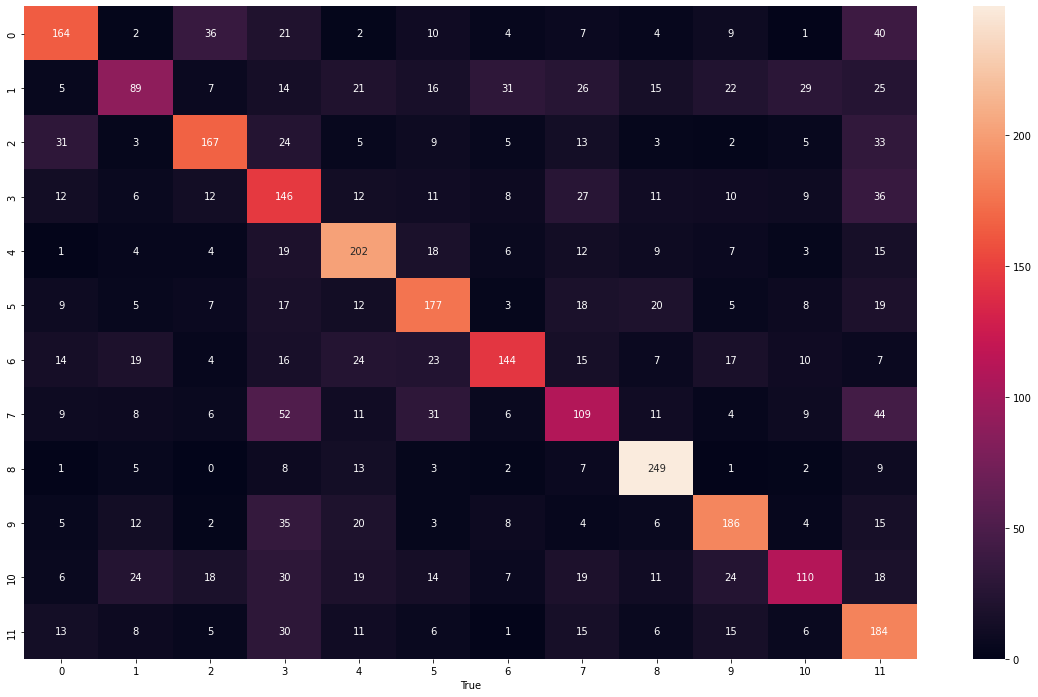

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 7, tres capas convolucionales cada una con filtro de 32, resultado en validacion 51 % de accuracy**

In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(64, (3, 3), activation='relu', input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Dropout(0.35)),
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.2)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.2)),
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [ ]:
model.compile(optimizer=opt.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 124, 124, 64)      4864      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 64)      

In [ ]:
epochs=200
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/200
263/263 [==============================] - 7s 23ms/step - loss: 2.4722 - accuracy: 0.0951 - val_loss: 2.4358 - val_accuracy: 0.1264
Epoch 2/200
263/263 [==============================] - 5s 19ms/step - loss: 2.3963 - accuracy: 0.1373 - val_loss: 2.3182 - val_accuracy: 0.1597
Epoch 3/200
263/263 [==============================] - 5s 19ms/step - loss: 2.3357 - accuracy: 0.1594 - val_loss: 2.2365 - val_accuracy: 0.2178
Epoch 4/200
263/263 [==============================] - 5s 19ms/step - loss: 2.2617 - accuracy: 0.1979 - val_loss: 2.1198 - val_accuracy: 0.2692
Epoch 5/200
263/263 [==============================] - 5s 19ms/step - loss: 2.1502 - accuracy: 0.2532 - val_loss: 1.9897 - val_accuracy: 0.3244
Epoch 6/200
263/263 [==============================] - 5s 19ms/step - loss: 2.0468 - accuracy: 0.3002 - val_loss: 2.0143 - val_accuracy: 0.3175
Epoch 7/200
263/263 [==============================] - 5s 19ms/step - loss: 1.9643 - accuracy: 0.3324 - val_loss: 1.8486 - val_accuracy:

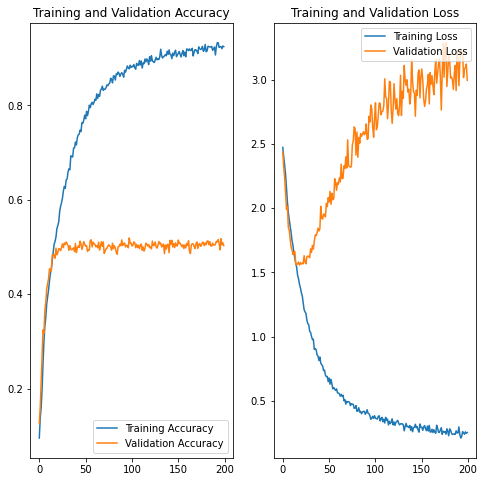

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.2108984738588333
Error mínimo (prueba):  1.5573444366455078
Porcentaje de clasificación máximo (entrenamiento):  0.9328571557998657
Porcentaje de clasificación máximo (prueba):  0.5191666483879089


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.60      0.62       300
           1       0.36      0.44      0.40       300
           2       0.50      0.51      0.51       300
           3       0.26      0.34      0.30       300
           4       0.62      0.55      0.58       300
           5       0.49      0.47      0.48       300
           6       0.66      0.54      0.59       300
           7       0.42      0.34      0.37       300
           8       0.84      0.80      0.82       300
           9       0.66      0.65      0.66       300
          10       0.35      0.34      0.34       300
          11       0.40      0.46      0.42       300

    accuracy                           0.50      3600
   macro avg       0.52      0.50      0.51      3600
weighted avg       0.52      0.50      0.51      3600



Text(0.5, 87.0, 'True')

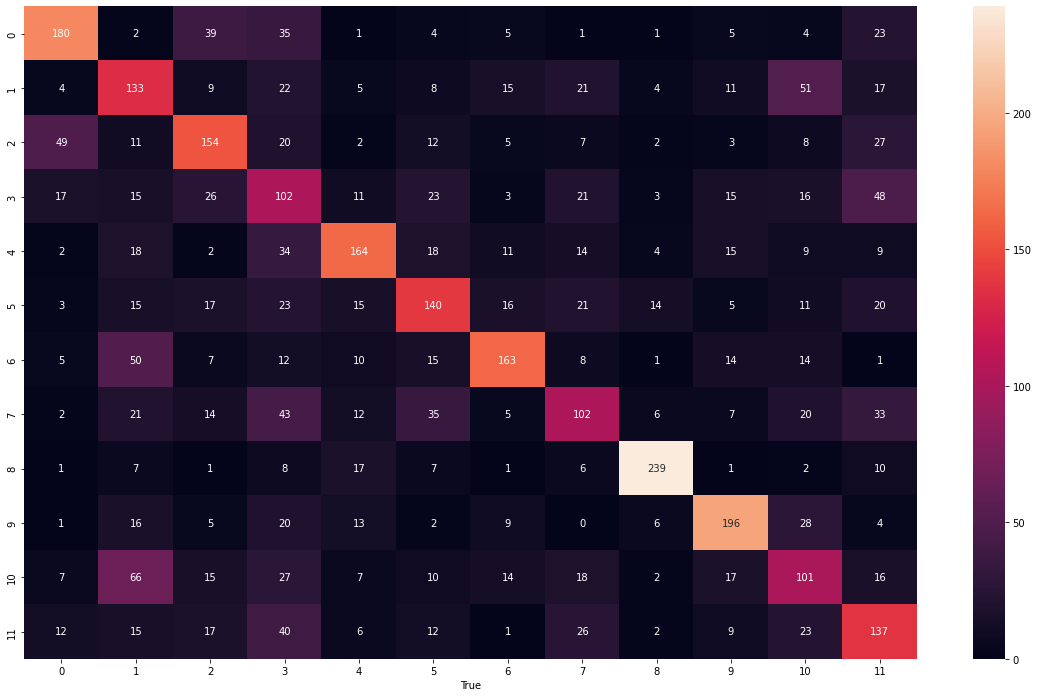

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 8, tres capas convolucionales cada una con filtro de 64, batchnormalization en capa convolucional y un dropout de 0.2 entre redes Dense, resultado en validacion 57 % de accuracy con optimizador Nadam**

In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(64, (3, 3), input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization()) # agregado
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization()) # agregado
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.2)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [ ]:
model.compile(optimizer=opt.Nadam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
epochs=200
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/200
263/263 [==============================] - 27s 44ms/step - loss: 2.2184 - accuracy: 0.2324 - val_loss: 3.9904 - val_accuracy: 0.0881
Epoch 2/200
263/263 [==============================] - 10s 39ms/step - loss: 1.9578 - accuracy: 0.3437 - val_loss: 2.4484 - val_accuracy: 0.2158
Epoch 3/200
263/263 [==============================] - 10s 39ms/step - loss: 1.8143 - accuracy: 0.4077 - val_loss: 1.9576 - val_accuracy: 0.3400
Epoch 4/200
263/263 [==============================] - 10s 39ms/step - loss: 1.6737 - accuracy: 0.4490 - val_loss: 1.9143 - val_accuracy: 0.3800
Epoch 5/200
263/263 [==============================] - 10s 38ms/step - loss: 1.5678 - accuracy: 0.4860 - val_loss: 1.9193 - val_accuracy: 0.3964
Epoch 6/200
263/263 [==============================] - 10s 38ms/step - loss: 1.4701 - accuracy: 0.5181 - val_loss: 1.8914 - val_accuracy: 0.4036
Epoch 7/200
263/263 [==============================] - 10s 38ms/step - loss: 1.3702 - accuracy: 0.5526 - val_loss: 1.7058 - val_ac

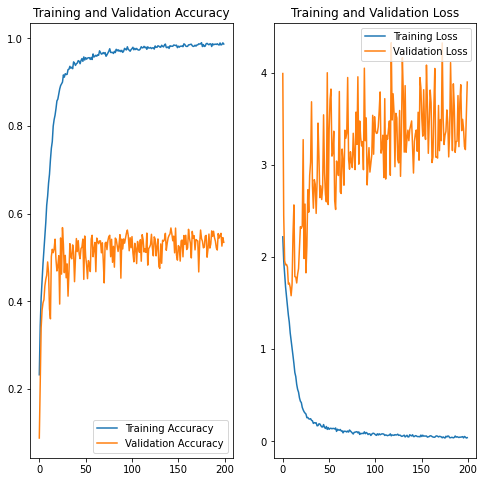

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.03481682389974594
Error mínimo (prueba):  1.5791091918945312
Porcentaje de clasificación máximo (entrenamiento):  0.9898809790611267
Porcentaje de clasificación máximo (prueba):  0.5680555701255798


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.41      0.78      0.54       300
           1       0.42      0.27      0.33       300
           2       0.52      0.67      0.59       300
           3       0.35      0.47      0.40       300
           4       0.79      0.51      0.62       300
           5       0.72      0.42      0.53       300
           6       0.64      0.53      0.58       300
           7       0.50      0.31      0.39       300
           8       0.74      0.84      0.78       300
           9       0.65      0.59      0.62       300
          10       0.42      0.48      0.45       300
          11       0.55      0.56      0.55       300

    accuracy                           0.53      3600
   macro avg       0.56      0.53      0.53      3600
weighted avg       0.56      0.53      0.53      3600



Text(0.5, 87.0, 'True')

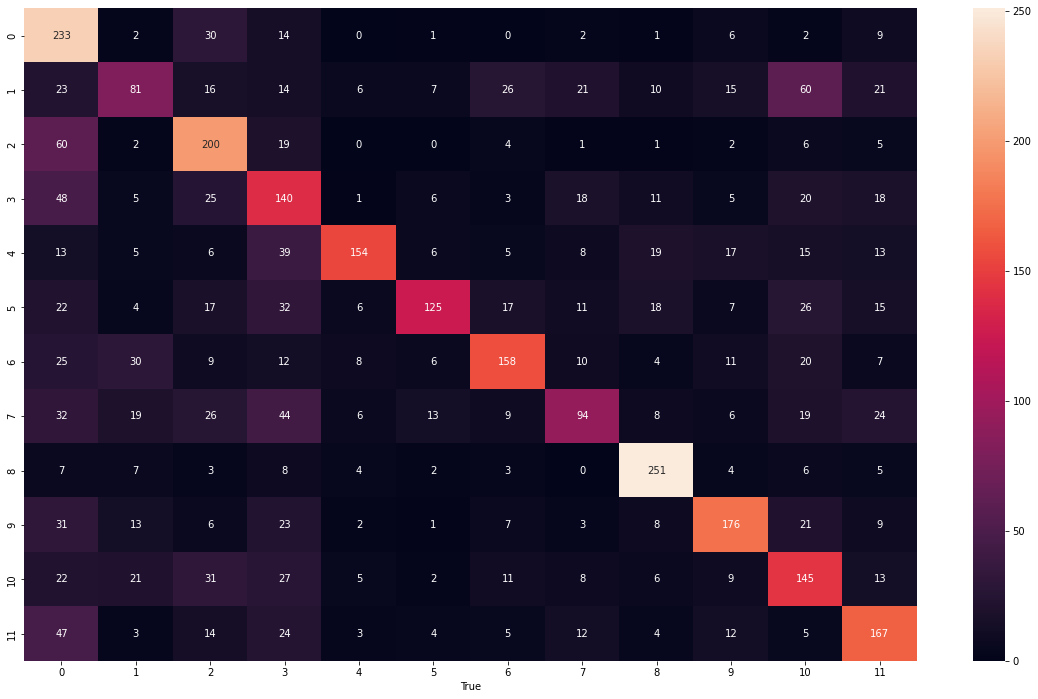

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')

### **Prueba Nro. 9, tres capas convolucionales cada una con filtro de 64, batchnormalization en capa convolucional y un dropout de 0.2 entre redes Dense,200 epocas de prueba, resultado en validacion 57 % de accuracy con optimizador Adam**

In [ ]:
num_classes = 12
model = Sequential()
model.add(L.Conv2D(64, (3, 3), input_shape=(img_height, img_width, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization()) # agregado
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3), activation='relu',kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization()) # agregado
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Conv2D(64, (3, 3),kernel_initializer='glorot_normal'))
model.add(L.BatchNormalization())
model.add(L.ReLU())
model.add(L.MaxPooling2D((2, 2)))
model.add(L.Flatten()),
#----------------------
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
model.add(L.Dropout(0.2)),
model.add(L.Dense(32, kernel_initializer='glorot_normal',activation = 'relu'))
#--------------------------------
model.add(L.Dense(num_classes, activation = 'softmax', kernel_initializer='glorot_normal'))

In [ ]:
model.compile(optimizer=opt.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 64)      1792      
                                                                 
 batch_normalization_5 (Batc  (None, 126, 126, 64)     256       
 hNormalization)                                                 
                                                                 
 re_lu_5 (ReLU)              (None, 126, 126, 64)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        36928     
                                                                 
 batch_normalization_6 (Batc  (None, 61, 61, 64)      

In [ ]:
epochs=200
history = model.fit(
  x_train,y_train,batch_size = batch_size,
  validation_data=(x_test,y_test),
  epochs=epochs
)

Epoch 1/200
263/263 [==============================] - 19s 28ms/step - loss: 2.2705 - accuracy: 0.2087 - val_loss: 3.3359 - val_accuracy: 0.0856
Epoch 2/200
263/263 [==============================] - 6s 23ms/step - loss: 2.0383 - accuracy: 0.3124 - val_loss: 2.3411 - val_accuracy: 0.2125
Epoch 3/200
263/263 [==============================] - 6s 23ms/step - loss: 1.8919 - accuracy: 0.3615 - val_loss: 1.9765 - val_accuracy: 0.3328
Epoch 4/200
263/263 [==============================] - 6s 23ms/step - loss: 1.7663 - accuracy: 0.4126 - val_loss: 1.9681 - val_accuracy: 0.3381
Epoch 5/200
263/263 [==============================] - 6s 23ms/step - loss: 1.6474 - accuracy: 0.4557 - val_loss: 2.1514 - val_accuracy: 0.3378
Epoch 6/200
263/263 [==============================] - 6s 23ms/step - loss: 1.5535 - accuracy: 0.4831 - val_loss: 1.8084 - val_accuracy: 0.4014
Epoch 7/200
263/263 [==============================] - 6s 23ms/step - loss: 1.4494 - accuracy: 0.5185 - val_loss: 1.7720 - val_accuracy

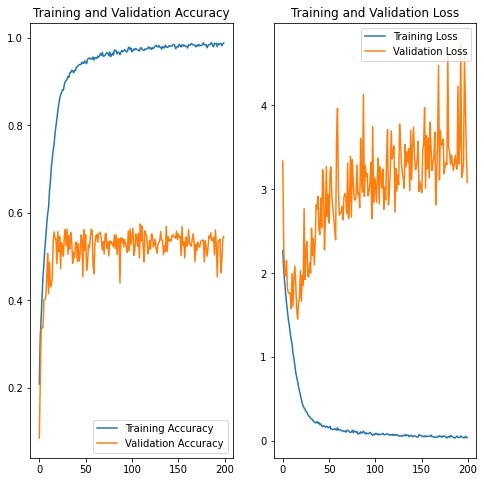

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
print('Error mínimo (entrenamiento): ', min(loss))
print('Error mínimo (prueba): ', min(val_loss))
print('Porcentaje de clasificación máximo (entrenamiento): ', max(acc))
print('Porcentaje de clasificación máximo (prueba): ', max(val_acc))

Error mínimo (entrenamiento):  0.035892974585294724
Error mínimo (prueba):  1.4544031620025635
Porcentaje de clasificación máximo (entrenamiento):  0.9886904954910278
Porcentaje de clasificación máximo (prueba):  0.5744444727897644


In [ ]:
y_predict = model.predict(x_test)
y_test1 = np.argmax(y_test, axis = -1)
y_predict_class = [np.argmax(elements, axis=-1) for elements in y_predict]
print("Classification Report: \n", classification_report(y_test1,np.transpose(y_predict_class)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.59      0.51      0.55       300
           1       0.39      0.34      0.36       300
           2       0.61      0.59      0.60       300
           3       0.44      0.42      0.43       300
           4       0.63      0.64      0.64       300
           5       0.50      0.63      0.56       300
           6       0.59      0.71      0.64       300
           7       0.41      0.43      0.42       300
           8       0.79      0.84      0.81       300
           9       0.71      0.57      0.63       300
          10       0.38      0.46      0.41       300
          11       0.56      0.42      0.48       300

    accuracy                           0.55      3600
   macro avg       0.55      0.55      0.54      3600
weighted avg       0.55      0.55      0.54      3600



Text(0.5, 87.0, 'True')

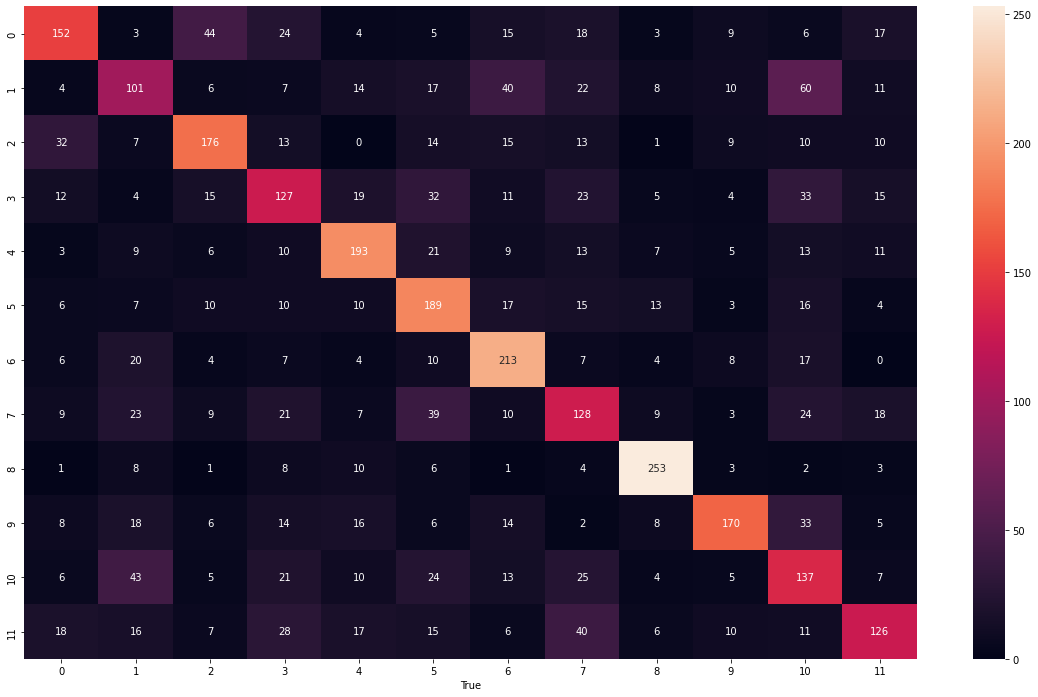

In [ ]:
conf_mat = tf.math.confusion_matrix(labels=y_test1,predictions=y_predict_class)
plt.figure(figsize=(20,12))
sn.heatmap(conf_mat, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.xlabel('True')